# Monte Carlo integration of POMDP Bellman operator

Dynamic programs can be solved using a mathematical object called the Bellman operator

$argmax_{A}\left\{ R(x_t,a) + E[V(x_{t+1})|x_t,a)]\right\}.$

When solving parially obsevable markov decision process the current state of the system is unknown. In this case we can solve the probem by replacing the sttae variable $x_t$ with the decision maker beleifs about the state of the system $B_t$  

$argmax_{A}\left\{ E[R(x_t,a)|B_t] + E[V(B_{t+1})|B_t,a)]\right\}.$

Although it does not look much more complex, in this notation, the expactations within the operator are much more dificult to evaluate. First, there is a second expectation that needs to be evaluated becasue the rewards depend on the unknown current state of the system. Furthermore, the second term now requires that we integrate over the uncertianty in the current state of the system, any unknowns or stochasticity related to the systems dynamics and the obervational error. 

These issues can be addressed with Monte Carlo methods. 

The basic idea will be to use a method inspired by sequential Monte Carlo or particle filtering methods. We will start by sampling $N_{samples}$ possible states $x_t$ from the beleif distribution $B_t$. We can then simulate the state transitions $x_{t+1}$ and reward $R(x_t,a)$ for each of the particles.  The expected rewards can be estiamted by $E[R(x_t,a)] = \frac{1}{N_{samples}}\sum_{n=1}^{N_{samples}}R_n$. Then from each, or a subset of the samples $x_{t+1}$ we can then sample observations $y_{t+1}$ from the observation process $g(y_t|x_t,a)$, and reweight the samples to aproximate the beleif state. 

In [ ]:
using Plots
using Distributions
using PlotThemes
using StatsBase
theme(:dark)
include("../examples/partially_observed_fishery.jl")
include("../POMP/particle_filter.jl")
include("utils.jl")

## Define function for example problem

To evaluate the operator above we need to define three things. We need to be able to simulate state transitions and rewards `x_t, R = T(x,a)` to simulate observations given the underlying state `y_t = G(x_t,a)` and we need to be able to calucuate the likelihoods `L = G(y_t|x_t,a)`. 

In [577]:
#parameters
pars = partially_observed_fishery.pars

# transition function 
function T!(x,a)
    return partially_observed_fishery.T!(x,a,pars)
end

# likelihood function 
function G(x,y,a)
    return partially_observed_fishery.G(x,y,a,pars)
end

# simulate observations
function G_sim(x,a)
    return partially_observed_fishery.G_sim(x,a,pars)
end 


G_sim (generic function with 1 method)

# Step 1: draw hidden state samples 

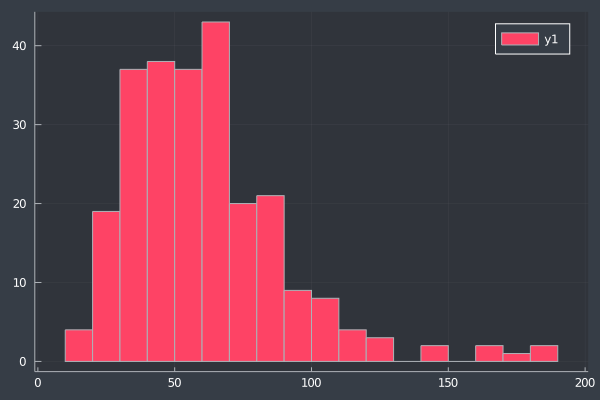

In [578]:
# set beleif state
Ex = 4.0
Vx = 0.2
d = Distributions.Normal(Ex,sqrt(Vx))
    
# samples
N_samples = 250
xt = broadcast(i->rand(d,1),1:N_samples)
weights = repeat([1/N_samples],N_samples)

# plot histogram
Plots.histogram(exp.(utils.reshape(xt)))

Expceded Abundance: 40.46404852761287Expceded Profit: 1.1444158636715112

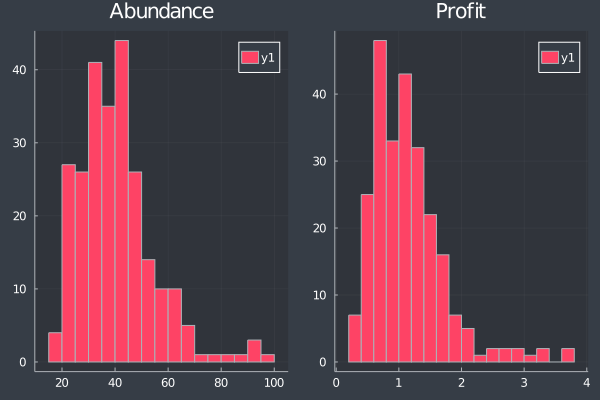

In [579]:
# simulate state transitions 
a = 0.5
out = broadcast(x -> T!(x,a), xt) # simulate step for each particle 
xt1 = broadcast(i->out[i][1], 1:N_samples) # get updated states 
R = broadcast(i->out[i][2].*weights[i], 1:N_samples) # calculate expected rewards 
p1 = Plots.histogram(exp.(utils.reshape(xt1)), title = "Abundance")
p2 = Plots.histogram(R, title = "Profit")
print("Expceded Abundance: ")
print(sum(exp.(utils.reshape(xt1)))/N_samples)
print("Expceded Profit: ")
print(sum(R)/N_samples)
plot(p1,p2)

Expceded Abundance: 45.45321323705862

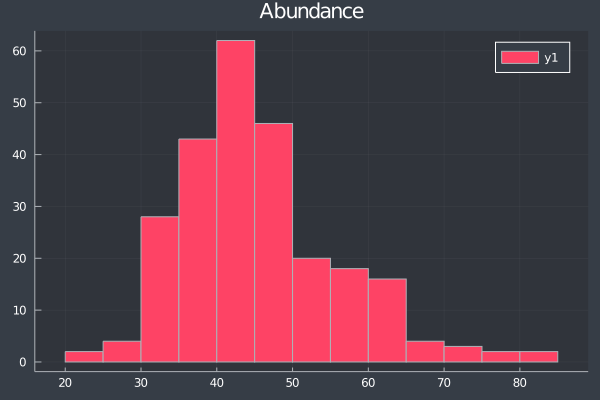

In [580]:
# example of state update
y = G_sim(xt1[1],a)
weights = broadcast(x -> G(x,y,a), xt1)
weights .*= 1/sum(weights)
xt1_ = StatsBase.sample(xt1,StatsBase.pweights(weights), N_samples)
p1 = Plots.histogram(exp.(utils.reshape(xt1_)), title = "Abundance")
print("Expceded Abundance: ")
print(sum(exp.(utils.reshape(xt1_)))/N_samples)
plot(p1)

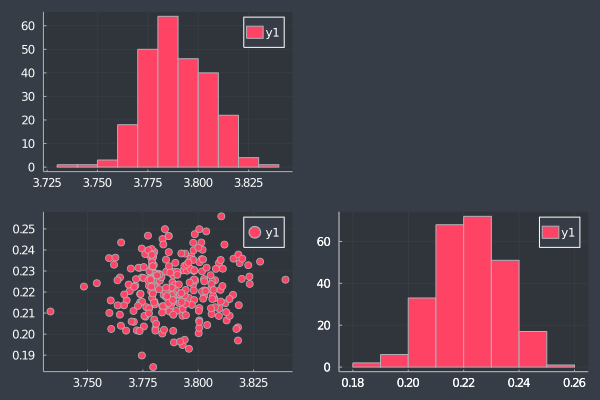

In [581]:
# simulate beleif state transitions
Ex_ = []
Vx_ = []

for i in 1:floor(Int,N_samples)
    y = G_sim(xt1[1],a)
    inds = sample(1:N_samples, floor(Int,N_samples))
    weights = broadcast(x -> G(x,y,a),xt1[inds])
    weights .*= 1/sum(weights)
    xt1__ = utils.reshape(xt1_[inds])
    mu = sum(xt1__.*weights)
    sigma = sqrt(sum(weights.*(xt1__ .- mu).^2))
    push!(Ex_, mu)
    push!(Vx_,sigma)
end 
p1 = Plots.histogram(Ex_)
p2 = Plots.histogram(Vx_)
p3 = Plots.scatter(Ex_,Vx_)
plot(p1,p2,p3,p2, layout = (2,2))

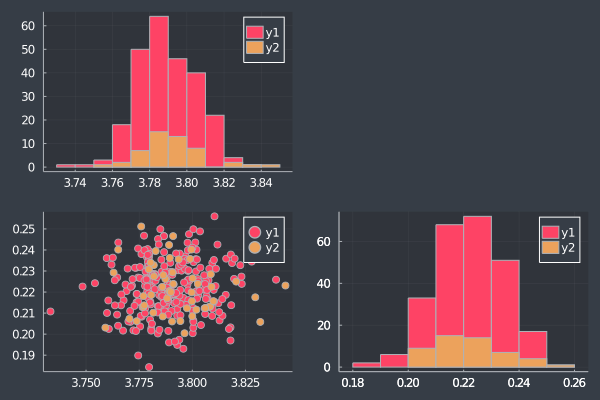

In [582]:
# simulate beleif state transitions
Ex_ = []
Vx_ = []

for i in 1:floor(Int,N_samples/5)
    y = G_sim(xt1[1],a)
    inds = sample(1:N_samples, floor(Int,N_samples))
    weights = broadcast(x -> G(x,y,a),xt1[inds])
    weights .*= 1/sum(weights)
    xt1__ = utils.reshape(xt1_[inds])
    mu = sum(xt1__.*weights)
    sigma = sqrt(sum(weights.*(xt1__ .- mu).^2))
    push!(Ex_, mu)
    push!(Vx_,sigma)
end 
Plots.histogram!(p1,Ex_)
Plots.histogram!(p2,Vx_)
Plots.scatter!(p3,Ex_,Vx_)
plot(p1,p2,p3,p2, layout = (2,2))

# Test MC Bellman functions


In [750]:
include("MC_POMDP.jl")
include("chebyshev_Q.jl")
include("Q_data.jl")
POMP_ = particle_filter.POMP([[0]],[1.0], 1, G, G_sim, T!)

function init_samples!(POMP,N,B)
    particle_filter.init_samples!(POMP,N,B)
    POMP.samples = broadcast(x->[x], POMP.samples)
end 


function stat(samples, weights)
    samples, weights = utils.reshape(samples), weights
    mu = sum(samples.*weights)
    sigma = sqrt(sum((samples .- mu).^2 .* weights))
    return [mu,sigma ]
end 

q_data = Q_data.init_Q_data(10000, 0.95, 2, 1)
Q_ = chebyshev_Q.init_Q_discrete([-0.1,0.00001],[6.5,1.5],7,10,collect(0.1:0.1:1.0),true)
delta = 0.95

POMDP_ = MC_POMDP.POMDP(POMP_,stat,init_samples!,q_data,Q_,delta)
print(" ")

In [751]:
MC_POMDP.MC_Bellman([4.0,0.5],3,POMDP_,100, 2)

3

298.6053105337704

In [753]:
MC_POMDP.opt_step!(POMDP_, 1000,0.9, 0.0, 50, 10)
for i in 1:10
    print(i)
    print("  ")
    MC_POMDP.opt_step!(POMDP_, 1000,0.5, 0.0, 50, 10)
end 

for i in 1:10
    print(i)
    print("  ")
    MC_POMDP.opt_step!(POMDP_, 500,0.25, 0.75, 100, 50)
end 

1  2  3  4  5  6  7  8  9  10  1  2  3  4  5  6  7  8  9  10  

In [754]:
for i in 1:10
    print(i)
    print("  ")
    MC_POMDP.opt_step!(POMDP_, 1000,0.1, 0.9, 200, 25)
end 

1  2  3  4  5  6  7  8  9  10  

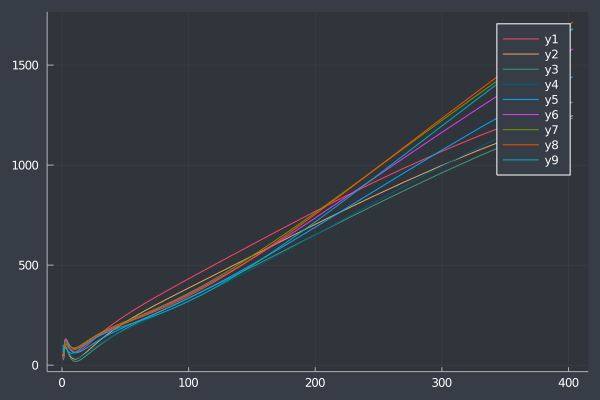

In [760]:
x = -1:0.1:6
y = broadcast(x -> POMDP_.Q.max_(POMDP_.Q, [x,0.1])[1], x)
p1 = Plots.plot(exp.(x),y)
for sigma in 0.2:0.1:0.9
    y = broadcast(x -> POMDP_.Q.max_(POMDP_.Q, [x,sigma])[1], x)
    Plots.plot!(p1,exp.(x),y)
end 
p1

In [759]:
POMDP_.Q.argmax_(POMDP_.Q,[0.5,0.5])

1.0